<div style="line-height:1.2;">

<h1 style="color:#BF66F2; margin-bottom: 0.3em;"> Convolutional Neural Networks in PyTorch 4 </h1>

<h4 style="margin-top: 0.3em; margin-bottom: 1em;"> Transformations in PyTorch on the CIFAR10 dataset.  </h4>

<div style="line-height:1.4; margin-bottom: 0.5em;">
    <h3 style="color: lightblue; display: inline; margin-right: 0.5em;">Keywords:</h3> 
    cv2 + transformers + albumentations + IPython.display
</div>

</div>

<div style = "line-height:0.5">
<h1 style = "color:#BF66F2 ">  Convolutional Neural Networks in PyTorch 4 </h1>
<h4> Transformations in PyTorch on the CIFAR10 dataset. </h4>
</div>
<div style="margin-top: -18px;">
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3>
    cv2 + transformers + albumentations + IPython.display + 
</span>
</div>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  #use environment variable to ignore CUDA warnings when GPU is not in use

In [51]:
import time
import random 
import cv2 #opencv
import numpy as np
from matplotlib import pyplot as plt        #import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as Func
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets  
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

import albumentations as Albu
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Resize

from PIL import Image

from tqdm import tqdm

from IPython.display import Image, display

In [3]:
class CNN(nn.Module):
    """ A simple Convolutional Neural Network (CNN) with two convolutional layers, \\
    followed by max-pooling layers and a fully connected one.

    Args:
        - Number of input channels [int]
        - Number of output classes [int]

    Attributes:
        - conv1 (nn.Conv2d): First convolutional layer.
        - pool (nn.MaxPool2d): Max-pooling layer.
        - conv2 (nn.Conv2d): Second convolutional layer.
        - fc1 (nn.Linear): Fully connected layer.

    Methods:
        - forward(x): Forward pass of the CNN.
        - initialize_weights(): Initialize the weights and biases of the network's layers.
    """
    def __init__(self, in_channels, num_classes):
        """ Initialize the CNN, defining all layers. """
        super().__init__()
        ####### First convolutional layer
        self.conv1 = nn.Conv2d(
            in_channels = in_channels,
            out_channels = 8,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )
        # Max-pooling layer to reduce spatial dimensions
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        ####### Second convolutional layer
        self.conv2 = nn.Conv2d(
            in_channels = 8,
            out_channels = 16,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )
        # Fully connected (linear) layer to produce the final output
        self.fc1 = nn.Linear(16 * 8 * 8, num_classes)

    def forward(self, x):
        """ Forward pass of the CNN.

        Parameters:
            Input tensor.

        Details: 
            - Apply ReLU activation to the output of the first convolutional layer
            - Apply max-pooling to reduce spatial dimensions
            - Apply ReLU activation to the output of the second convolutional layer
            - Apply max-pooling again
            - Reshape the tensor to match the expected input shape of the fully connected layer

        Returns:
            Output reshaped tensor through the fully connected layer
        """
        x = Func.relu(self.conv1(x))
        x = self.pool(x)
        x = Func.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        
        return self.fc1(x)
    
    def initialize_weights(self):
        """ Initialize the weights and biases of the network's layers. """        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Initialize weights for convolutional layers using Kaiming initialization
                nn.init.kaiming_uniform_(m.weight)

                if m.bias is not None:
                    # Initialize biases to zero
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                # Initialize weights of batch normalization layers to 1 and biases to 0
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                # Initialize weights for linear (fully connected) layers using Kaiming initialization
                # and biases to zero.
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

<h2 style = "color:#BF66F2 ">  <u> Example 1 </u> </h2>

In [5]:
""" Hyperparameters """
learning_rate = 3e-4  # for future copilot: this is karpathy's constant
batch_size = 64
num_epochs = 5

In [6]:
model = CNN(in_channels = 3, num_classes = 10)
model.classifier = nn.Sequential(nn.Linear(512, 100), nn.ReLU(), nn.Linear(100, 10))
model.to(device)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [7]:
""" Standarize the input to help the model to generalize.
Many transformations can be concatenated using 'Compose()'.
"""
my_transforms = transforms.Compose(
    [  
        transforms.Resize((36, 36)),                #resizes (32,32) to (36,36)
        transforms.RandomCrop((32, 32)),            #takes a random (32,32) crop section
        transforms.ColorJitter(brightness = 0.5),   #change brightness of image by 0.5
        transforms.RandomRotation(degrees = 45),    #rotate between -45 and 45 
        transforms.RandomHorizontalFlip(p = 0.5),   #flips the image horizontally with probability 0.5
        transforms.RandomVerticalFlip(p = 0.05),    #flips the image vertically with probability 0.5
        transforms.RandomGrayscale(p = 0.2),        #Converts to grayscale with probability 0.2
        transforms.ToTensor(),                      #converts PIL image to tensor so we can train w. pytorch
        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
    ]
)

In [8]:
train_dataset = datasets.CIFAR10(root = "dataset/", train = True, transform = my_transforms, download = True)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

Files already downloaded and verified


In [9]:
## Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [10]:
############ Train 
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loader):
        ## Get data to cuda if possible
        data = data.to(device = device)
        targets = targets.to(device = device)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss.item())
        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()

    print(f"Loss average over epoch {epoch} is {sum(losses)/len(losses):.3f}")

Loss average over epoch 0 is 2.024
Loss average over epoch 1 is 1.848
Loss average over epoch 2 is 1.788
Loss average over epoch 3 is 1.753
Loss average over epoch 4 is 1.715


In [11]:
def check_accuracy(loader, model):
    """ Check accuracy on training & test on a given data loader, to see how good our model. """
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    ## Initialize counters for correct predictions and total samples
    num_correct = 0
    num_samples = 0

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation for the following operations (no backpropagation)
    with torch.no_grad():
        # Iterate through the data loader to make predictions and compute accuracy
        for x, y in loader:
            # Move input data and target labels to the GPU
            x = x.to(device = device)
            y = y.to(device = device)

            # Forward pass: compute scores (logits) for each class
            scores = model(x)
            # Find the class with the highest score as the predicted class
            _, predictions = scores.max(1)
            
            # Update the count of correct predictions based on equality with target labels
            num_correct += (predictions==y).sum()
            # Update the total number of samples processed
            num_samples +=  predictions.size(0)

        # Calculate the accuracy as a percentage
        accuracy = float(num_correct) / float(num_samples) * 100
        print(f"Got {num_correct} / {num_samples} with accuracy {accuracy:.2f}%")

    # Set the model back to training mode for future training steps
    model.train()

In [12]:
check_accuracy(train_loader, model)

Checking accuracy on training data
Got 19707 / 50000 with accuracy 39.41%


<div style = "line-height:0.7">
<h3 style = "color:#BF66F2 ">  <u> Image Augmentation with albumentations </u> </h3>
</div>
Albumentations is used to artificially increase the diversity of a training dataset by applying various transformations to the original images. <br>
These transformations can include rotations, flips, scaling, and brightness adjustments.

In [13]:
class ImageFolder(Dataset):
    """ Dataset class for loading image data organized in folders, where each subfolder represents a class. \\
    It inherits from torch.utils.data.Dataset and it allows for image loading, optional transformations, and retrieval \\
    of image-label pairs for machine learning tasks.

    Args:
        - The root directory containing subdirectories for each class [str]
        - A function/transform to apply to the loaded image [callable]

    Attributes:
        - List of tuples, each containing the image file name and its class label [list]
        - Root directory where the image data is located [str]
        - Function to apply transformation to the loaded image [callable, optional]
        - List of class names corresponding to subdirectories in root_dir [list]

    Methods:
        - __init__(root_dir, transform = None): Initializes the dataset.
        - __len__(): Returns the total number of data samples in the dataset.
        - __getitem__(index): Retrieves a specific data sample given an index.
    """    
    def __init__(self, root_dir, transform = None):
        """ Constructor method, initializes the dataset with the root directory and optional transformations. """
        super(ImageFolder, self).__init__()
        self.data = []
        # Store the root directory where the image data is located
        self.root_dir = root_dir
        # Store the data transformation 
        self.transform = transform
        # Get a list of class names by listing subdirectories in the root directory
        self.class_names = os.listdir(root_dir)

        for index, name in enumerate(self.class_names):
            # List all files in the subdirectory associated with the current class
            files = os.listdir(os.path.join(root_dir, name))
            # Create a list of tuples, where each tuple contains the file name and the class index
            self.data +=  list(zip(files, [index] * len(files)))

    def __len__(self):
        """ Return the total number of data samples in the dataset. """
        return len(self.data)

    def __getitem__(self, index):
        """ Retrieve a specific data sample given an index. """
        # Extract the image file name and its corresponding label (class index) from the dataset
        img_file, label = self.data[index]
        # Construct the full path to the image file.
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])
        # Load the image as a NumPy array using PIL.
        image = np.array(Image.open(os.path.join(root_and_dir, img_file)))

        ### Apply data transformations
        if self.transform is not None:
            augmentations = self.transform(image = image)
            image = augmentations["image"]

        return image, label

In [14]:
""" Create an Image Augmentation pipeline with Compose, by applying a series of image transformations to input images. """

transform = Albu.Compose(
    [
        # Resize the image to a width of 1920 pixels and a height of 1080 pixels
        Albu.Resize(width = 1920, height = 1080),
        # Crop to a width of 1280 pixels and a height of 720 pixels
        Albu.RandomCrop(width = 1280, height = 720),
        # Rotate the image by a random angle, up to a limit of 40 degrees, with a probability of 0.9
        Albu.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        # Apply horizontal flip with a probability of 0.5
        Albu.HorizontalFlip(p = 0.5),
        # Apply vertical flip with a probability of 0.1
        Albu.VerticalFlip(p = 0.1),
        # Randomly shift the R,G,B color channels by up to 25 intensity levels with a probability of 0.9
        Albu.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        
        # Apply one of two transformations: blur or color jittering
        Albu.OneOf(
            [
                Albu.Blur(blur_limit = 3, p = 0.5),
                Albu.ColorJitter(p = 0.5),
            ],
            p = 1.0,
        ),
        # Normalize the pixel values of the image by subtracting mean [0, 0, 0], dividing by std [1, 1, 1], and scaling to [0, 1]
        Albu.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        
        # Convert the augmented image to a tensor
        ToTensorV2(),
    ]
)

In [15]:
dataset = ImageFolder(root_dir = "./dataset/cat_dogs", transform = transform)

for x, y in dataset:
    print(x.shape)

torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])


<h2 style = "color:#BF66F2 ">  <u> Example 2 </u> </h2>
Mean and Standard Deviation

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_set = datasets.CIFAR10(root = "dataset/", transform = transforms.ToTensor(), download = True)
train_loader = DataLoader(dataset = train_set, batch_size = 64, shuffle = True)

Files already downloaded and verified


In [17]:
def get_mean_std(loader):
    """ Calculate the mean and standard deviation given a DataLoader.
        = > var[X] = E[X**2] - E[X]**2 
    """
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    # Iterate through the data loader using tqdm for progress tracking
    for data, _ in tqdm(loader):
        # Calculate the sum of channel means along dimensions
        channels_sum +=  torch.mean(data, dim = [0, 2, 3])
        # Calculate the sum of channel means squared along dimensions
        channels_sqrd_sum +=  torch.mean(data**2, dim = [0, 2, 3])
        num_batches +=  1
    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean**2) ** 0.5

    return mean, std


In [18]:
mean, std = get_mean_std(train_loader)
mean, std

  0%|          | 0/782 [00:00<?, ?it/s]

100%|██████████| 782/782 [00:16<00:00, 48.54it/s]


(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [38]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color = BOX_COLOR, thickness = 2):
    """ Add bounding box on the subjects of the image. """
    # Unpack the bounding box coordinates and dimensions
    x_min, y_min, w, h = bbox
    # Convert coordinates and dimensions to integers
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    # Draw a rectangle on the image using OpenCV
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color = color, thickness = thickness)
    # Calculate text size for class name placement
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    # Draw a filled rectangle for class name background
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    # Add the class name as text using OpenCV
    cv2.putText(
        img,
        text = class_name,
        org = (x_min, y_min - int(0.3 * text_height)),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX,
        fontScale = 0.35, 
        color = TEXT_COLOR, 
        lineType = cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name, desired_sizes_fig):
    """ Visualize the image with bounding boxes. """
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        # Call visualize_bbox to add bounding boxes and class names to the image
        img = visualize_bbox(img, bbox, class_name)
    # Display the image with bounding boxes
    plt.figure(figsize = (desired_sizes_fig[0], desired_sizes_fig[1]))
    plt.axis('off')
    plt.imshow(img)

In [20]:
immm = cv2.imread('data/catdogmask.png')
gray = cv2.cvtColor(immm, cv2.COLOR_BGR2GRAY)

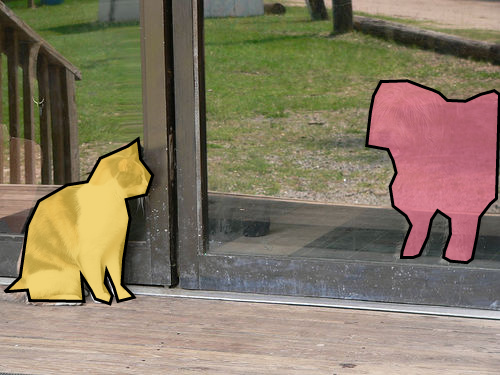

In [49]:
""" Display the image in notebooks with IPython.display."
N.B.
# Passing directly 'immm' does not work since 'cv2.imread()' reads an image as a NumPy array, 
and the Image class from IPython.display expects a file path or a URL, not a NumPy array.
#display(Image(data = immm)) 

If the path is unknow just save the img to a temporary file that can be opened with 'display()', then remove the file.
"""

## When the exact path is know do this:
#tempo = 'data/catdogmask.png'
#display(Image(filename=tempo))

#### Without finding the path 
temp_filename = 'temp_image.png'
cv2.imwrite(temp_filename, immm)
display(Image(filename=temp_filename))
os.remove(temp_filename)

In [54]:
""" Open the masked image in a new window.

N.B. 1
    This is not working ... avoid ! 
    Current thread (0x55aaf4f5e330) is not the object's thread (0x55aaf50ac1c0).
    #imm_wrong = Image.open('data/catdogmask.png')
    #imm_wrong.show()
N.B. 2
    To avoid to block the Kernel the cv2 image is shown inside a block monitered by a timer, to interrupt the execution after 3 secs.
    Otherwise, the program will get stuck spamming the message: 
    "QObject::moveToThread: Current thread (0x7da1220) is not the object's thread..."
"""
start_time = time.time()
end_time = start_time + 3

while True:
    if time.time() <= end_time:
        cv2.imshow("myimag", immm)
        # Add a short delay is fundamental to allow OpenCV to process events and open image correctly
        cv2.waitKey(3)
    else: 
        break

# Close the image window
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x7da1220) is not the object's thread (0x7f898c0).
Cannot move to target thread (0x7da1220)

QObject::moveToThread: Current thread (0x7da1220) is not the object's thread (0x7f898c0).
Cannot move to target thread (0x7da1220)

QObject::moveToThread: Current thread (0x7da1220) is not the object's thread (0x7f898c0).
Cannot move to target thread (0x7da1220)

QObject::moveToThread: Current thread (0x7da1220) is not the object's thread (0x7f898c0).
Cannot move to target thread (0x7da1220)

QObject::moveToThread: Current thread (0x7da1220) is not the object's thread (0x7f898c0).
Cannot move to target thread (0x7da1220)

QObject::moveToThread: Current thread (0x7da1220) is not the object's thread (0x7f898c0).
Cannot move to target thread (0x7da1220)

QObject::moveToThread: Current thread (0x7da1220) is not the object's thread (0x7f898c0).
Cannot move to target thread (0x7da1220)

QObject::moveToThread: Current thread (0x7da1220) is not the object's thread

In [23]:
bboxes = [[5.66, 138.95, 147.09, 164.88], [366.7, 80.84, 132.8, 181.84]]
category_ids = [17, 18]

# Map from 'category_id' to the class name to visualize the class label for the bounding box on the image
category_id_to_name = {17: 'cat', 18: 'dog'}

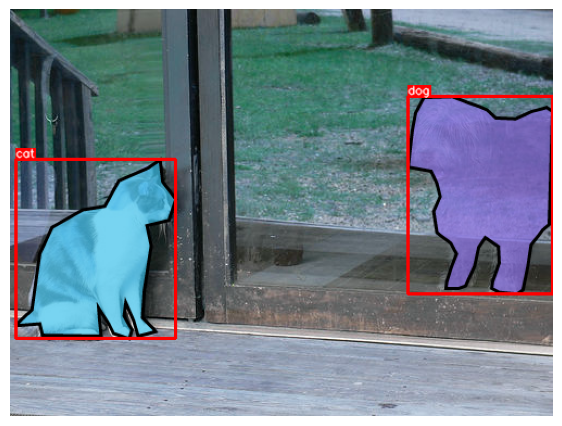

In [60]:
visualize(immm, bboxes, category_ids, category_id_to_name, (7,7))

<h3 style = "color:#BF66F2 ">  <u> Image Augmentation pipeline </u> </h3>

In [25]:
transform = Albu.Compose(
    [
        # Crop a random part of the input and rescale it to some size without loss of bboxes
        Albu.RandomSizedBBoxSafeCrop(width = 448, height = 336, erosion_rate = 0.2)],
        # Define bounding box parameters for the transformation
        bbox_params = Albu.BboxParams(format = 'coco', label_fields = ['category_ids']),
)

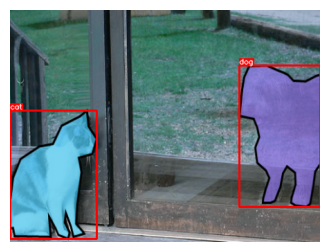

In [57]:
random.seed(7)
desired_sizes_fig = [4,4]
transformed = transform(image = immm, bboxes = bboxes, category_ids = category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
    desired_sizes_fig,
)

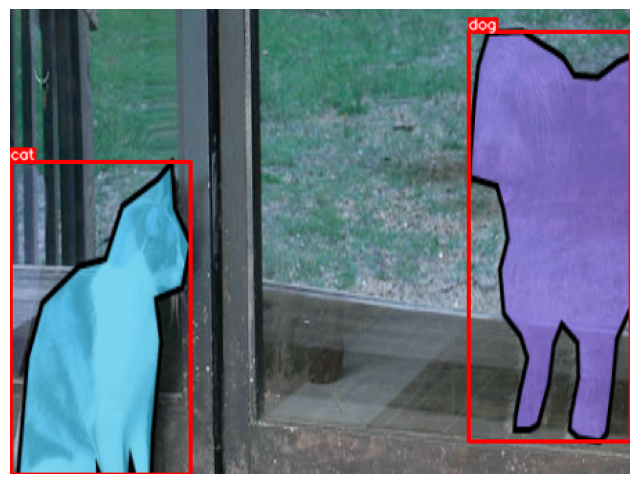

In [56]:
random.seed(3)
desired_sizes_fig = (8,8)
transformed = transform(image = immm, bboxes = bboxes, category_ids = category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
    desired_sizes_fig
)

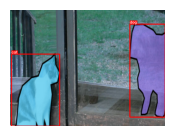

In [61]:
desired_sizes_fig = (2,7)

# Transformations pipeline
transformed = transform(
    image=immm,
    bboxes=bboxes,
    category_ids=category_ids,
)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
    desired_sizes_fig
)